<a href="https://colab.research.google.com/github/hackers108/Ads-CTR-Forecasting-Using-SARIMAX/blob/main/Ads_CTR_Forecasting_Using_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import files
uploaded = files.upload()


Saving ctr.csv to ctr (1).csv


In [10]:
import pandas as pd
df = pd.read_csv("ctr.csv")  # Replace with actual file name if different
df.head()



,Date,Clicks,Impressions
0,2022-10-19,2851,58598
1,2022-10-20,2707,57628
2,2022-10-21,2246,50135
3,2022-10-22,1686,40608
4,2022-10-23,1808,41999


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Clicks'] = df['Clicks'].interpolate()
df['Impressions'] = df['Impressions'].interpolate()
df['CTR'] = (df['Clicks'] / df['Impressions']) * 100
df.head()


,Clicks,Impressions,CTR
Date,,,
2022-10-19,2851,58598,4.865354
2022-10-20,2707,57628,4.697369
2022-10-21,2246,50135,4.479904
2022-10-22,1686,40608,4.151891
2022-10-23,1808,41999,4.304864


In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Clicks'], mode='lines', name='Clicks'))
fig.add_trace(go.Scatter(x=df.index, y=df['Impressions'], mode='lines', name='Impressions'))
fig.update_layout(title='Clicks and Impressions Over Time')
fig.show()


In [14]:
fig = px.scatter(df, x='Impressions', y='Clicks', title='Clicks vs Impressions')
fig.update_layout(xaxis_title='Impressions', yaxis_title='Clicks')
fig.show()


In [15]:
fig = px.line(df, x=df.index, y='CTR', title='Click-Through Rate Over Time')
fig.show()


In [16]:
df['DayOfWeek'] = df.index.dayofweek
day_avg_ctr = df.groupby('DayOfWeek')['CTR'].mean().reset_index()
day_avg_ctr['DayOfWeek'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig = px.bar(day_avg_ctr, x='DayOfWeek', y='CTR', title='Average CTR by Day of the Week')
fig.show()


In [17]:
df['DayCategory'] = df['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
avg_ctr_cat = df.groupby('DayCategory')['CTR'].mean().reset_index()

fig = px.bar(avg_ctr_cat, x='DayCategory', y='CTR', title='CTR: Weekday vs Weekend')
fig.update_layout(yaxis_title='Average CTR')
fig.show()


In [18]:
grouped = df.groupby('DayCategory')[['Clicks', 'Impressions']].sum().reset_index()

fig = px.bar(grouped, x='DayCategory', y=['Clicks', 'Impressions'],
             title='Total Clicks and Impressions by Day Type',
             labels={'value': 'Count', 'variable': 'Metric'},
             barmode='group')
fig.update_layout(yaxis_title='Count')
fig.show()


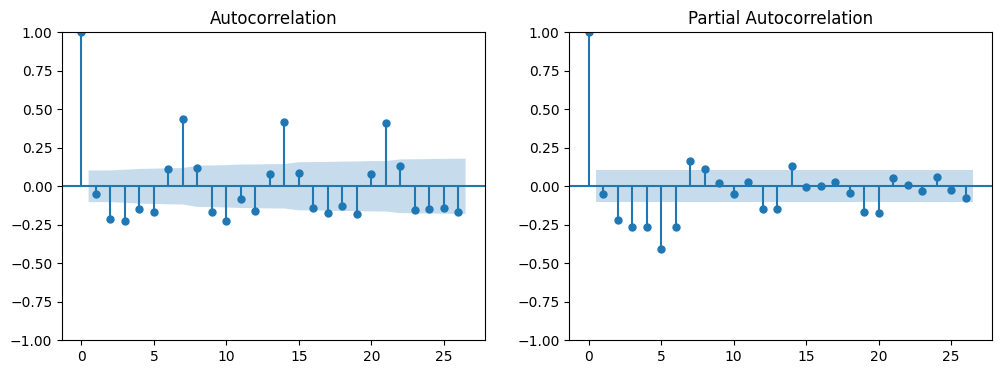

In [19]:
differenced = df['CTR'].diff().dropna()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced, ax=ax[0])
plot_pacf(differenced, ax=ax[1])
plt.show()


In [20]:
p, d, q, s = 1, 1, 1, 12
model = SARIMAX(df['CTR'], order=(p, d, q), seasonal_order=(p, d, q, s))
results = model.fit()
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                CTR   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -71.365
Date:                            Mon, 28 Jul 2025   AIC                            152.731
Time:                                    02:35:48   BIC                            172.049
Sample:                                10-19-2022   HQIC                           160.418
                                     - 10-18-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5263      0.070      7.513      0.000       0.389       0.664
ma.L1         -0.9049      0.036   

In [21]:
future_steps = 100
forecast = results.predict(start=len(df), end=len(df) + future_steps - 1)

forecast_df = pd.DataFrame({'Original': df['CTR'], 'Forecast': forecast})
forecast_df.index = forecast_df.index.to_list()[:len(df)] + list(pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps))

fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['Original'], name='Actual CTR'))
fig.add_trace(go.Scatter(x=forecast_df.index[-future_steps:], y=forecast_df['Forecast'][-future_steps:], name='Forecasted CTR'))
fig.update_layout(title='CTR Forecasting using SARIMAX', xaxis_title='Date', yaxis_title='CTR')
fig.show()
